# Adalet Veyis Turgut
# Ufuk Arslan
# Zuhal Didem Aytaç

In [1]:
!nvidia-smi

Fri Jan 14 18:13:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install pytorch-lightning --quiet
!pip install transformers --quiet

     |████████████████████████████████| 526 kB 5.2 MB/s 
     |████████████████████████████████| 829 kB 58.6 MB/s 
     |████████████████████████████████| 596 kB 54.5 MB/s 
     |████████████████████████████████| 133 kB 65.9 MB/s 
     |████████████████████████████████| 332 kB 62.2 MB/s 
     |████████████████████████████████| 1.1 MB 54.0 MB/s 
     |████████████████████████████████| 271 kB 75.1 MB/s 
     |████████████████████████████████| 160 kB 71.2 MB/s 
     |████████████████████████████████| 192 kB 54.0 MB/s 
     |████████████████████████████████| 3.4 MB 5.1 MB/s 
     |████████████████████████████████| 67 kB 4.8 MB/s 
     |████████████████████████████████| 895 kB 70.2 MB/s 
     |████████████████████████████████| 3.3 MB 55.9 MB/s 


In [3]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer
from transformers import BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl

from torchmetrics.functional import auroc,f1,accuracy
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 101

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Global seed set to 101


101

In [4]:
!gdown --id 1RLkAIT-oCfg3vhut74mzGCcU08Wx_9Mb
!gdown --id 1YR3oPrldVZs2iV8KK7GCKT_nunYHP8fG

Downloading...
From: https://drive.google.com/uc?id=1RLkAIT-oCfg3vhut74mzGCcU08Wx_9Mb
To: /content/formatted_dev.csv
100% 7.62M/7.62M [00:00<00:00, 46.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YR3oPrldVZs2iV8KK7GCKT_nunYHP8fG
To: /content/formatted_train.csv
100% 30.3M/30.3M [00:00<00:00, 115MB/s] 


In [5]:
train_df = pd.read_csv("formatted_train.csv")
val_df = pd.read_csv("formatted_dev.csv")


## Preprocessing


['Treatment', 'Diagnosis', 'Prevention', 'Mechanism', 'Transmission', 'Epidemic Forecasting', 'Case Report']


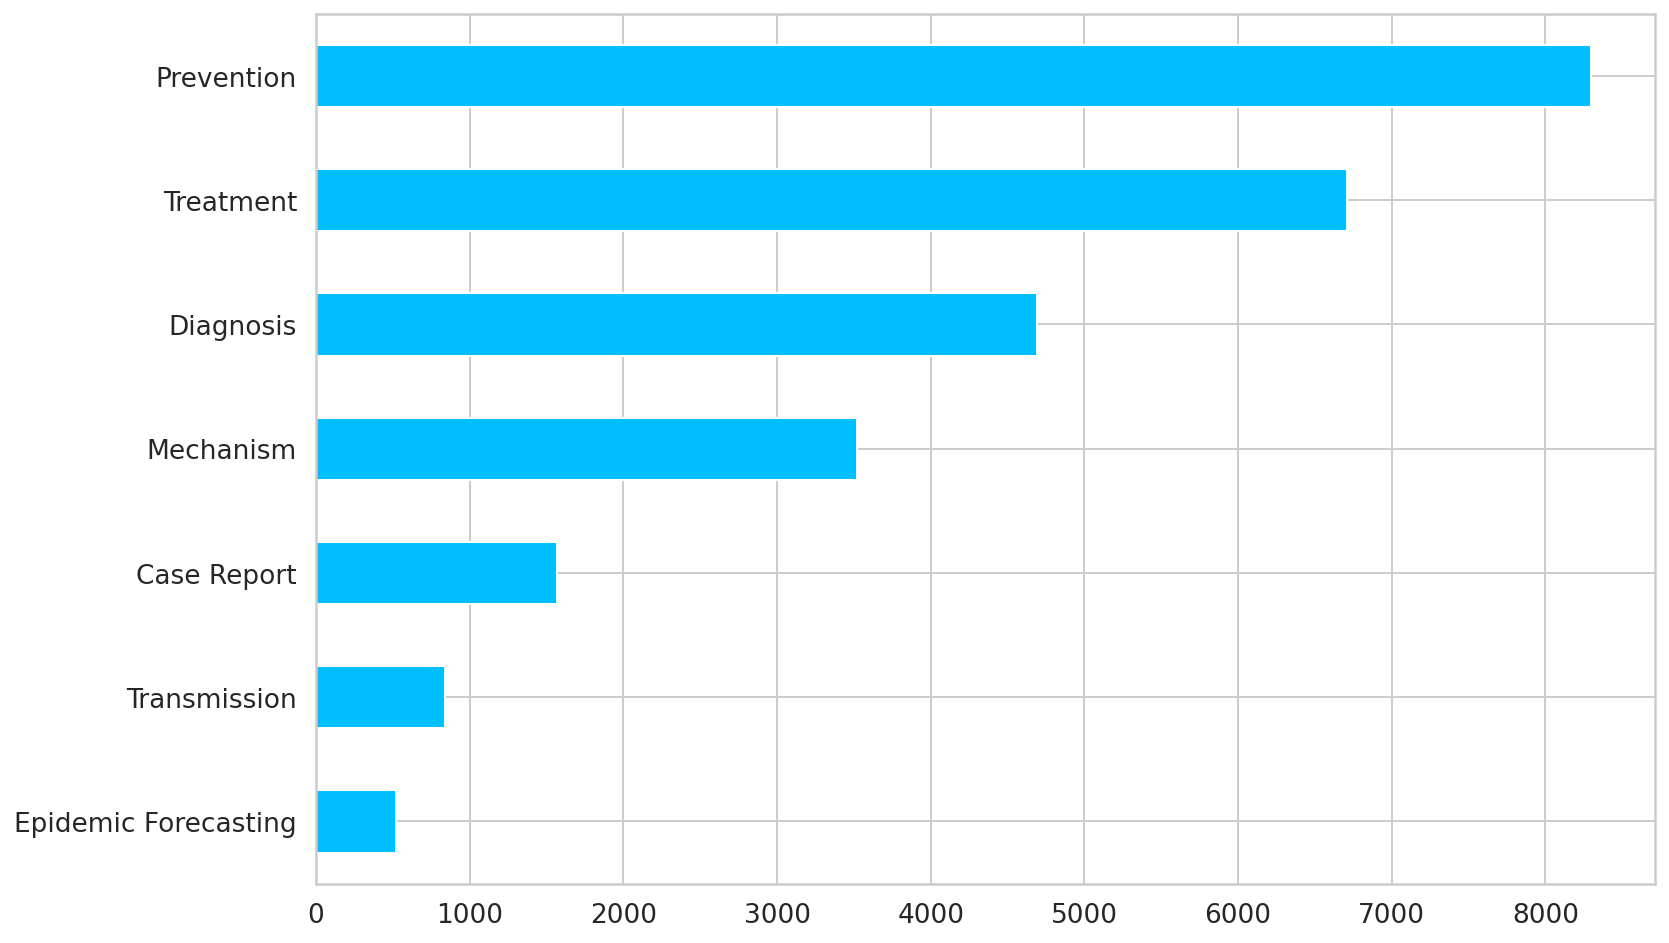

In [6]:
LABEL_COLUMNS = train_df.columns.tolist()[4:]
print(LABEL_COLUMNS)
for label in LABEL_COLUMNS:
    train_df[label] = pd.to_numeric(train_df[label], errors='coerce').astype('Int64')
train_df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

### Tokenization

We need to convert the raw text into a list of tokens. For that, we'll use the built-in BertTokenizer:

In [7]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["Text"], 
    max_length=512, 
    truncation=True
  ))
  token_counts.append(token_count)
sns.histplot(token_counts)
plt.xlim([0, 512]);

In [8]:
#Maximum we can do is 512
MAX_TOKEN_COUNT = 512

### Dataset

We'll wrap the tokenization process in a PyTorch Dataset, along with converting the labels to tensors:

In [9]:
class AbstractDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 512
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    abstract = data_row.Text
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
      abstract,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return dict(
      abstract=abstract,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor([int(y) for x,y in labels.items()])
    )

In [10]:
train_dataset = AbstractDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)


Let's load the BERT model

In [11]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The larger version of BERT has more attention heads and a larger hidden size.

We'll wrap our custom dataset into a [LightningDataModule](https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html):

In [13]:
class AbstractDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = AbstractDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = AbstractDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [14]:
N_EPOCHS = 3
BATCH_SIZE = 10

data_module = AbstractDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

## Model

Our model will use a pre-trained [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and a linear layer to convert the BERT representation to a classification task. We'll pack everything in a [LightningModule](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html):


In [15]:
class AbstractTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)


  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

### Optimizer scheduler

The job of a scheduler is to change the learning rate of the optimizer during training. This might lead to better performance of our model. We'll use the [get_linear_schedule_with_warmup](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#transformers.get_linear_schedule_with_warmup).

Let's have a look at a simple example to make things clearer:

In [16]:
dummy_model = nn.Linear(2, 1)

optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
  optimizer, 
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])

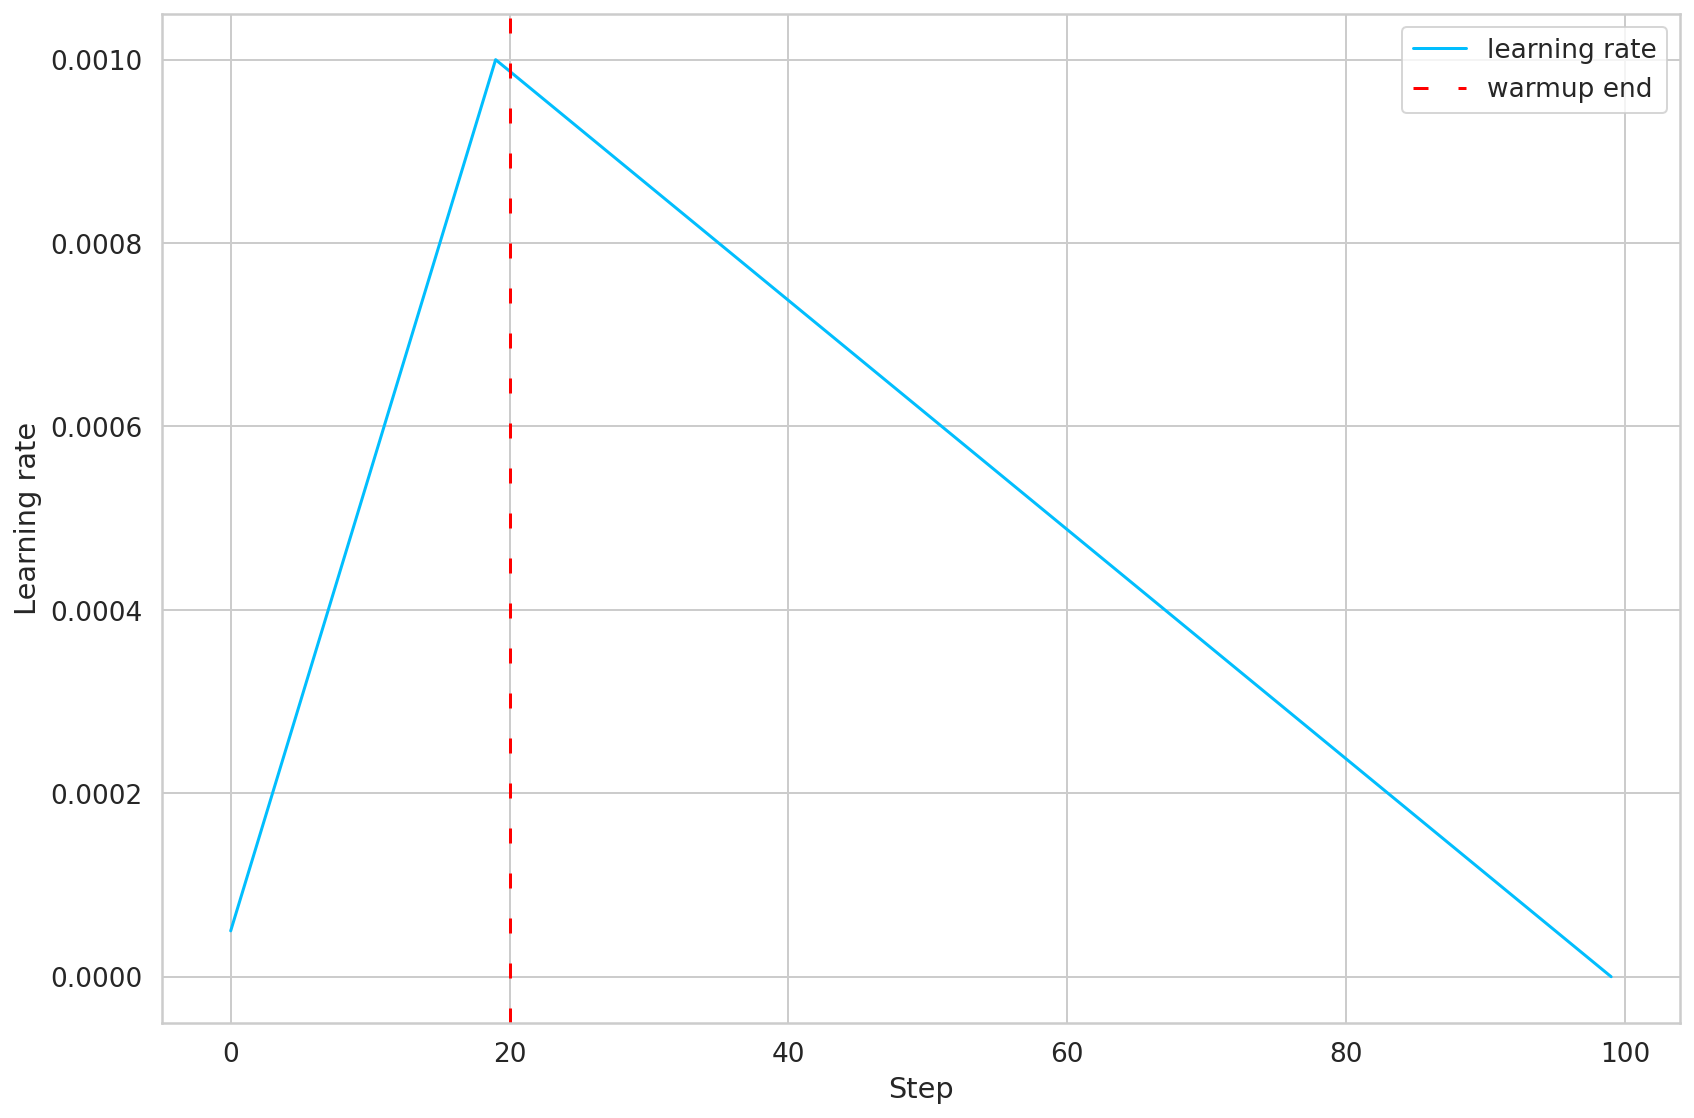

In [17]:
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

We simulate 100 training steps and tell the scheduler to warm up for the first 20. The learning rate grows to the initial fixed value of 0.001 during the warm-up and then goes down (linearly) to 0.

To use the scheduler, we need to calculate the number of training and warm-up steps. The number of training steps per epoch is equal to `number of training examples / batch size`. The number of total training steps is `training steps per epoch * number of epochs`:

In [18]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

We'll use a fifth of the training steps for a warm-up:

In [19]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(1137, 5688)

We can now create an instance of our model:

In [20]:
model = AbstractTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Training

In [21]:
!rm -rf lightning_logs/
!rm -rf checkpoints/

In [22]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

Log the progress in TensorBoard:

In [23]:
logger = TensorBoardLogger("lightning_logs", name="abstract")

And early stopping triggers when the loss hasn't improved for the last 2 epochs (you might want to remove/reconsider this when training on real-world projects):

In [24]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

We can start the training process:

In [25]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f3638bd3a50>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f3638bd3a50>)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Tr

In [26]:
trainer.fit(model, data_module)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: lightning_logs/abstract

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 5.4 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.263   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1411. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 625. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
Global seed set to 101


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'labels', 'predictions'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1723. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 813. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1709. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an a

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Predictions


In [27]:
trained_model = AbstractTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
THRESHOLD = 0.5

test_comment = "The coronavirus disease 2019 (COVID-19) pandemic is straining the healthcare system, particularly for patients with severe outcomes requiring admittance to the intensive care unit (ICU). This study investigated the potential associations of obesity and diabetes with COVID-19 severe outcomes, assessed as ICU admittance. Medical history, demographic and patient characteristics of a retrospective cohort (1158 patients) hospitalized with COVID-19 were analysed at a single centre in Kuwait. Univariate and multivariate analyses were performed to explore the associations between different variables and ICU admittance. Of 1158 hospitalized patients, 271 had diabetes, 236 had hypertension and 104 required admittance into the ICU. From patients with available measurements, 157 had body mass index (BMI) >/=25 kg/m(2) . Univariate analysis showed that overweight, obesity class I and morbid obesity were associated with ICU admittance. Patients with diabetes were more likely to be admitted to the ICU. Two models for multivariate regression analysis assessed either BMI or diabetes on ICU outcomes. In the BMI model, class I and morbid obesities were associated with ICU admittance. In the diabetes model, diabetes was associated with increased ICU admittance, whereas hypertension had a protective effect on ICU admittance. In our cohort, overweight, obesity and diabetes in patients with COVID-19 were associated with ICU admittance, increasing the risk of poor outcomes."
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  #if prediction < THRESHOLD:
  #  continue
  print(f"{label}: {prediction}")

Treatment: 0.9876663684844971
Diagnosis: 0.9717403650283813
Prevention: 0.007313283625990152
Mechanism: 0.020346781238913536
Transmission: 0.003499274142086506
Epidemic Forecasting: 0.004422483034431934
Case Report: 0.005604322999715805


I definitely agree with those tags. It looks like our model is doing something reasonable, on those two examples.

## Evaluation

Let's get a more complete overview of the performance of our model. We'll start by taking all predictions and labels from the validation set:

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = AbstractDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/4754 [00:00<?, ?it/s]

One simple metric is the accuracy of the model:

In [31]:
accuracy(predictions, labels, threshold=THRESHOLD)

tensor(0.9597)

That's great, but you should take this result with a grain of salt. We have a very imbalanced dataset. Let's check the ROC for each tag:

In [32]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

AUROC per tag
Treatment: 0.9806838631629944
Diagnosis: 0.9786874651908875
Prevention: 0.9872942566871643
Mechanism: 0.9823830127716064
Transmission: 0.97335284948349
Epidemic Forecasting: 0.987182080745697
Case Report: 0.9853338003158569


In [33]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
  y_true, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0
))

                      precision    recall  f1-score   support

           Treatment       0.90      0.90      0.90      1681
           Diagnosis       0.88      0.89      0.88      1190
          Prevention       0.95      0.93      0.94      2085
           Mechanism       0.91      0.85      0.88       828
        Transmission       0.65      0.70      0.67       185
Epidemic Forecasting       0.79      0.67      0.72       157
         Case Report       0.90      0.88      0.89       364

           micro avg       0.90      0.89      0.90      6490
           macro avg       0.85      0.83      0.84      6490
        weighted avg       0.90      0.89      0.90      6490
         samples avg       0.92      0.91      0.90      6490



In [53]:
import csv
with open('bert_results.csv', 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(["PMID","Case Report","Diagnosis","Epidemic Forecasting","Mechanism","Prevention","Transmission","Treatment"])
    i = 0
    for predict in predictions:
      pred = list(predict.numpy())
      row = [i, pred[6],pred[1], pred[5], pred[3], pred[2], pred[4], pred[0]]
      writer.writerow(row) # Writes formatted rows to the new file
      i +=1